# Spark

This notebook is an accumulation of different algorithm implementations and experimentations with PySpark. It consists of the following parts:

* Part 1 - Word Count
* Part 2 - Covid Government Response Index Score Tracker and Association Rule Mining
* Part 3 - Page Rank
* Part 4 - K-Means



## Setup

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u382-ga-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
import numpy as np
import pandas as pd

from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import re

from tqdm import tqdm

%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## Part 1 - Word Count in Spark

This Spark program outputs the number of words that start with each English letter for the *plotsummaries.txt* data file which was extracted from the CMU Book Summary Dataset (https://www.cs.cmu.edu/~dbamman/booksummaries.html) and contains plot summaries of more than 16 thousand books extracted from Wikipedia.


In [ ]:
# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

In [ ]:
# Helper functions
def lower_str(word):
    """
    INPUT:
        word: string
    OUTPUT:
        modified_wrod: string

    NOTE: output the given word in lower case letters.
    """

    return word.lower()

def strip_punc(word):
    """
    INPUT:
        word: string
    OUTPUT:
        modified_wrod: string

    NOTE: output the given word with characters stripped.
    """

    punc = punc = '!"“”#$%&\'()*+,.:;<=>?@[\\]^_`{|}-~/'
    for ch in punc:
        word = word.replace(ch, '')
    return word

In [ ]:
# Load textfile
rdd = spark.sparkContext.textFile("plotsummaries.txt")
# Convert to all lowercase and strip punctuation
rdd = rdd.map(lower_str)
rdd = rdd.map(strip_punc)

In [ ]:
# Split words
rdd = rdd.flatMap(lambda line: line.split(" "))

# Remove whitespaces
rdd = rdd.filter(lambda x : x!=' ')
rdd = rdd.filter(lambda x : x!='')

# Only include words that start with an alphabetic character
rdd = rdd.filter(lambda x : x[0] in 'abcdefghijklmnopqrstuvwxyz')

rdd.take(5)

['old', 'major', 'the', 'old', 'boar']

In [ ]:
# Word count based on first letter
rdd_count = rdd.map(lambda word:(word[0],1))
rdd_count_rbk = rdd_count.reduceByKey(lambda x,y:(x+y)).sortByKey()
counts = rdd_count_rbk.collect()
print(counts)

[('a', 892437), ('b', 358189), ('c', 313756), ('d', 236723), ('e', 164448), ('f', 303000), ('g', 132567), ('h', 518633), ('i', 417423), ('j', 55831), ('k', 62747), ('l', 183722), ('m', 258569), ('n', 135926), ('o', 399201), ('p', 229874), ('q', 12811), ('r', 202222), ('s', 462904), ('t', 1196461), ('u', 73971), ('v', 51267), ('w', 371728), ('x', 1453), ('y', 29141), ('z', 5795)]


In [ ]:
# Write to file
# Output format: <letter>,<count>
f = open("WordCounts.txt", "w")
for i in range(len(counts)-1):
    f.write("{},{}\n".format(counts[i][0], counts[i][1]))
f.write("{},{}".format(counts[-1][0], counts[-1][1]))
f.close()

In [ ]:
# stop the spark instance
sc.stop()

## Part 2 - Oxford Covid-19 Government Response Tracker

In [ ]:
# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

### Part 2a - Computing the Government Response Index Score

This Spark program computes the Government Response Index Score for each state in the United States for each month in 2020 and 2021. The government response index is a proxy for how strict the policies imposed by the government are for a period t in a state. This index is computed as the average of the individual sub-indices, one for each of the 16 indicators: C1, C2, C3, C4, C5, C6, C7, C8, E1, E2, H1, H2, H3, H3, H6, H7, H8.

The sub-indices for each indicator is calculated based on the following formula:
    
    I = 100 * [v - 0.5 (F - f)] / N
    where v = the recorded policy value on the ordinal scale
          N = the maximum value of the indicator
          F = whether that indicator has a flag (1 if yes, 0 if not)
          f = the recorded binary flag for that indicator

The indicator value for a month is then the majority value during the month. If there are ties, then we take the larger value (1 for flags). When no data is available for the entire period, you can safely assume the minimal value for that indicator.


In [ ]:
# Read the csv
OxCGRT_latest = spark.read.option("header", True).csv("OxCGRT_USA_latest.csv")
OxCGRT_latest.show()

+-------------+-----------+----------+----------+------------+--------+------------------+--------+---------------------+--------+------------------------+--------+------------------------------+--------+--------------------------+--------+-----------------------------+--------+-------------------------------------+--------+----------------------------------+-----------------+-------+-----------------------+------------------+------------------------+-------------------------------+-------+-----------------+------------------+-------------------------------------+-------------------------+--------------------+--------+---------------------+-------+--------------------------------+--------+-----------+-----------------------------------+----------------------------------+-------------------------------------------------------------------------------+--------------------------------------------------------------------+--------------------------------------------------+-------------+-----

In [ ]:
##### GLOBAL VARIABLES #####
# Indicators dictionary {indicator name: max indicator value}
indicators = {"C1M_School closing": 3,
"C2M_Workplace closing": 3,
"C3M_Cancel public events": 2,
"C4M_Restrictions on gatherings": 4,
"C5M_Close public transport": 2,
"C6M_Stay at home requirements": 3,
"C7M_Restrictions on internal movement": 2,
"C8EV_International travel controls": 4,
"E1_Income support": 2,
"E2_Debt/contract relief": 2,
"H1_Public information campaigns": 2,
"H2_Testing policy": 3,
"H3_Contact tracing": 2,
"H6M_Facial Coverings": 4,
"H7_Vaccination policy": 5,
"H8M_Protection of elderly people": 3}

# Indicator flags
indicator_flags = ["C1M_Flag",
"C2M_Flag",
"C3M_Flag",
"C4M_Flag",
"C5M_Flag",
"C6M_Flag",
"C7M_Flag",
"E1_Flag",
"H1_Flag",
"H6M_Flag",
"H7_Flag",
"H8M_Flag"]

# Indicators with flags = 0
nonFlags = set(["C8", "E2", "H2", "H3"])

In [ ]:
# Helper functions

def clean_data(df):
    """
    INPUT:
        df: spark dataframe
    OUTPUT:
        cleaned data: spark dataframe

    NOTE: output the given word with characters stripped.
    """
    # Set of all the cols we need
    col_set = set(indicators).union(set(indicator_flags))
    col_set.add("RegionName")
    col_set.add("Date")

    # Only keep the cols we need
    df = df.select([c for c in df.columns if c in col_set])

    # Filter out all the regions that are null
    df = df.filter("RegionName is not NULL")

    # Only keep the dates in 2020 and 2021 and change date format to MM-YYYY
    df = df.filter((df["Date"].substr(1, 4) == "2020") | (df["Date"].substr(1, 4) == "2021"))
    df = df.withColumn("Date", concat_ws("-",
        substring(df["Date"], 5, 2),  # month
        substring(df["Date"], 1, 4)   # year
    ))

    return df


def impute_data(df):
    """
    INPUT:
        df: spark dataframe
    OUTPUT:
        imputed data: spark dataframe

    NOTE: output the dataframe with nan values replaced with the minimal value of the given indicator.
    """
    # Fill all null indicator values as 0
    for indicator in indicators:
        df = df.na.fill("0.00", indicator)
    # Fill all null flag values as 0
    for flag in indicator_flags:
        df = df.na.fill("0", flag)

    return df

def group_and_aggregate_data(df):
    """
    INPUT:
        df: spark dataframe
    OUTPUT:
        groupe and aggregated data: spark dataframe

    NOTE: output the dataframe with grouped (by month) and aggregated (based on the algorithm) data.
    """
    def aggFunc(values):
        """
        Get mode and break ties using the largest value
        """
        counts = Counter(values) # counts is {item: count}
        # We are sorting based on the largest count and break ties with largest value
        sortedCounts = sorted(counts.items(), key=lambda x: (-float(x[1]), -float(x[0])))
        return sortedCounts[0][0]

    # Define custom mode function
    modeUDF = udf(aggFunc, StringType())

    # For each indicator and flag, we groupby RegionName and Date and aggregate
    # using our custom mode function
    cols = list(indicators.keys()) + indicator_flags
    aggregation = [modeUDF(collect_list(col)).alias(col) for col in cols]
    df_new = df.groupBy("RegionName", "Date").agg(*aggregation)

    return df_new

def compute_index_score(df):
    """
    INPUT:
        df: spark dataframe
    OUTPUT:
        list of index scores per region and period: list

    NOTE: output a list of computed scores per region and period based on the algorithm.
    """

    def calcSubIndex(v, F, f, N):
        """
        Implements the sub-index calculation
        I = 100 * [v - 0.5 (F - f)] / N
        where v = indicator value
              N = max indcator value
              F = flag
              f = max flag
        """
        if float(v) == 0.0:
            return 0.0
        return 100.0 * (float(v) - 0.5 * (F - float(f))) / N

    # We define a custom function for calculating the indicator
    calcIndicator_udf = udf(lambda v, f: calcSubIndex(v, F, f, N), FloatType())

    # Calculate indicator
    for indicator in indicators:
        i = indicator[:2]
        N = float(indicators[indicator])
        if i in nonFlags:
            F = 0.0
        else:
            F = 1.0
        for f in indicator_flags:
            if f[:2] == i:
                flag = f
                break
        df = df.withColumn("I"+i, calcIndicator_udf(df[indicator], df[flag]))

    # Average indicators
    cols = [indicator for indicator in df.columns if indicator[0] == 'I']
    cols_sum = df[cols[0]]
    for c in cols[1:]:
        cols_sum += df[c]
    result_df = df.withColumn("Indicator", cols_sum / 16.0)

    result_df = result_df.select("RegionName", "Date", "Indicator").orderBy(df["RegionName"], df["Date"].substr(4, 7), df["Date"].substr(1, 2))
    scoresList = [tuple(row) for row in result_df.collect()]

    return scoresList

In [ ]:
# Clean the data
df_clean = clean_data(OxCGRT_latest)
df_clean = impute_data(df_clean)
df_clean.show()

+----------+-------+------------------+--------+---------------------+--------+------------------------+--------+------------------------------+--------+--------------------------+--------+-----------------------------+--------+-------------------------------------+--------+----------------------------------+-----------------+-------+-----------------------+-------------------------------+-------+-----------------+------------------+--------------------+--------+---------------------+-------+--------------------------------+--------+
|RegionName|   Date|C1M_School closing|C1M_Flag|C2M_Workplace closing|C2M_Flag|C3M_Cancel public events|C3M_Flag|C4M_Restrictions on gatherings|C4M_Flag|C5M_Close public transport|C5M_Flag|C6M_Stay at home requirements|C6M_Flag|C7M_Restrictions on internal movement|C7M_Flag|C8EV_International travel controls|E1_Income support|E1_Flag|E2_Debt/contract relief|H1_Public information campaigns|H1_Flag|H2_Testing policy|H3_Contact tracing|H6M_Facial Coverings|H6

In [ ]:
# Group by RegionName and Date and aggregate based on mode
df_grouped = group_and_aggregate_data(df_clean)
df_grouped.show()

+----------+-------+------------------+---------------------+------------------------+------------------------------+--------------------------+-----------------------------+-------------------------------------+----------------------------------+-----------------+-----------------------+-------------------------------+-----------------+------------------+--------------------+---------------------+--------------------------------+--------+--------+--------+--------+--------+--------+--------+-------+-------+--------+-------+--------+
|RegionName|   Date|C1M_School closing|C2M_Workplace closing|C3M_Cancel public events|C4M_Restrictions on gatherings|C5M_Close public transport|C6M_Stay at home requirements|C7M_Restrictions on internal movement|C8EV_International travel controls|E1_Income support|E2_Debt/contract relief|H1_Public information campaigns|H2_Testing policy|H3_Contact tracing|H6M_Facial Coverings|H7_Vaccination policy|H8M_Protection of elderly people|C1M_Flag|C2M_Flag|C3M_Flag

In [ ]:
# Calculate scores
scoresList = compute_index_score(df_grouped)

In [ ]:
# Write to file
# Output format: <RegionName>,<Period(MM-YYYY)>,<GovernmentResponseIndex>
f = open("IndexScores.txt", "w")
for i in range(len(scoresList)-1):
    f.write("{},{},{}\n".format(scoresList[i][0], scoresList[i][1], scoresList[i][2]))
f.write("{},{},{}".format(scoresList[-1][0], scoresList[-1][1], scoresList[-1][2]))
f.close()

### Part 2b - Mining Association Rules

Association Rules can be used to discover interesting relations between government policies. This information could then be used to make policy recommendations.

This program first finds the frequent itemsets of size 2 and 3 with a support of s=100 (i.e. policies pairs/triplets that occur together at least 100
times are considered frequent).

For the pairs of items (X, Y) such that the support of {X, Y} is at least 100, this program then computes the confidence scores of the corresponding association rules: X ⇒ Y, Y ⇒ X.

For all triples (X, Y, Z) such that the support of {X, Y, Z} is at least 100, this program then computes the confidence scores of the corresponding association rules: (X, Y) ⇒ Z, (X, Z) ⇒ Y, (Y, Z) ⇒ X.

The rules are then sorted in decreasing order of confidence scores with ties sorted by lexicographically increasing order.

Note: Confidence is defined as the probability of occurrence of B in the basket if the basket already contains A: `conf(A → B) = Pr(B|A)`, where Pr(B|A) is the conditional probability of finding item set B given that item set A is present).


In [ ]:
def clean_data(df):
    """
      INPUT:
          df: spark dataframe
      OUTPUT:
          df: spark dataframe

      NOTE: Keep only the data that is needed
    """
    # Create a set of col names
    col_set = set(indicators)
    col_set.add('RegionName')
    col_set.add('Date')

    # Only keep the cols in col_set
    df = df.select([c for c in df.columns if c in col_set])

    # Filter out any regions that are NULL
    df = df.filter("RegionName is not NULL")

    # Only keep the first day of every month for years 2020 and 2021
    df = df.filter((df['Date'].substr(1, 4) == '2020') | (df['Date'].substr(1, 4) == '2021'))
    df = df.filter(df['Date'].substr(-2, 2) == '01')

    # Policy is active when indicator value is greater than 0
    for indicator in indicators:
        df = df.na.fill("0.00", indicator)
        df = df.withColumn(indicator, when(df[indicator] != "0.00", indicator).otherwise(None))

    return df

def transform_to_items(df):
    """
      INPUT:
          df: spark dataframe
      OUTPUT:
          list itemsets: list

      NOTE: output a list itemsets from given dataframe.
    """
    # Merge all the indicator values into a new column
    indicator = list(indicators.keys())
    #df = df.withColumn("items", array(*indicator))

    itemsets = data.rdd.map(lambda row: [col for col in indicator if row[col] is not None]).collect()

    # # Remove items that are null
    # df = df.withColumn("filtered_items", expr("filter(items, x -> x is not null)"))

    # # Create item sets
    # itemsets = df.select("filtered_items").rdd.flatMap(lambda item: item).collect()
    #itemsets = [set(row) for row in itemsets if row and len(row) > 0]

    return itemsets


In [ ]:
def get_frequent_itemsets(items, min_sup, itemset_size):
    """
    INPUT:
        items: list
        min_sup: the min support
    OUTPUT:
        list of frequent itemsets: list

    NOTE: output a list of frequent itemsets.
    """
    # Create RDD
    rdd = sc.parallelize(items)

    # Create combinations of size `itemset_size` from each set of items (sorted lexicographically)
    all_items = rdd.flatMap(lambda item: combinations(item, itemset_size)).map(lambda item: tuple(sorted(item)))

    # Count the occurences of each item set and filter out those less than the support value
    counts = all_items.map(lambda item: (item, 1)).reduceByKey(lambda x, y: x + y).filter(lambda x: x[1] >= min_sup)

    return counts


In [ ]:
# Clean the data and get the itemsets
cleaned_df = clean_data(OxCGRT_latest)
itemsets = transform_to_items(cleaned_df)
print(len(itemsets))

1224


Computing the frequent itemsets

In [ ]:
# Frequent itemsets of size 1
setsOf1 = get_frequent_itemsets(itemsets, 100, 1)
frequentIndicators = [x[0] for x in setsOf1.collect()]

In [ ]:
# Frequent itemsets of size 2 - pairs of (X,Y)
xy = get_frequent_itemsets(itemsets, 100, 2)
xy.take(5)

[(('C8EV_International travel controls', 'H2_Testing policy'), 1173),
 (('H1_Public information campaigns', 'H3_Contact tracing'), 1128),
 (('C1M_School closing', 'C3M_Cancel public events'), 867),
 (('C1M_School closing', 'C4M_Restrictions on gatherings'), 657),
 (('C1M_School closing', 'C6M_Stay at home requirements'), 715)]

In [ ]:
# Frequent itemsets of size 3 - triplets of (X,Y,Z)
xyz = get_frequent_itemsets(itemsets, 100, 3)
xyz.take(5)

[(('C8EV_International travel controls',
   'H1_Public information campaigns',
   'H2_Testing policy'),
  1128),
 (('C8EV_International travel controls',
   'H2_Testing policy',
   'H3_Contact tracing'),
  1173),
 (('C1M_School closing', 'C2M_Workplace closing', 'C3M_Cancel public events'),
  782),
 (('C1M_School closing',
   'C2M_Workplace closing',
   'C4M_Restrictions on gatherings'),
  649),
 (('C1M_School closing',
   'C2M_Workplace closing',
   'C6M_Stay at home requirements'),
  698)]

In [ ]:
# Itemsets ordered by the association rules for confidence score calculations
yx = xy.map(lambda item: ((item[0][1], item[0][0]), item[1]))
yzx = xyz.map(lambda item: ((item[0][1], item[0][2], item[0][0]), item[1]))
xzy = xyz.map(lambda item: ((item[0][0], item[0][2], item[0][1]), item[1]))

In [ ]:
# Have mapping of counts for each item for easier lookup in parts b) and c)
singlesDict = setsOf1.collectAsMap()
pairsDict = xy.union(yx).collectAsMap()
print(singlesDict)
print(pairsDict)

{('H1_Public information campaigns',): 1128, ('H3_Contact tracing',): 1173, ('C2M_Workplace closing',): 817, ('C5M_Close public transport',): 380, ('E1_Income support',): 900, ('E2_Debt/contract relief',): 990, ('H8M_Protection of elderly people',): 1075, ('H6M_Facial Coverings',): 1018, ('C8EV_International travel controls',): 1173, ('H2_Testing policy',): 1173, ('C1M_School closing',): 1017, ('C3M_Cancel public events',): 900, ('C4M_Restrictions on gatherings',): 657, ('C6M_Stay at home requirements',): 724, ('C7M_Restrictions on internal movement',): 914, ('H7_Vaccination policy',): 612}
{('C8EV_International travel controls', 'H2_Testing policy'): 1173, ('H1_Public information campaigns', 'H3_Contact tracing'): 1128, ('C1M_School closing', 'C3M_Cancel public events'): 867, ('C1M_School closing', 'C4M_Restrictions on gatherings'): 657, ('C1M_School closing', 'C6M_Stay at home requirements'): 715, ('C1M_School closing', 'C7M_Restrictions on internal movement'): 878, ('C1M_School clos

Confidences for corresponding association rules for item pairs

In [ ]:
# Calculate Confidences for X => Y association rules
xyConfidences = xy.map(lambda item: (item[0], float(item[1]) / float(singlesDict[(item[0][0],)])))
xyConfidences = xyConfidences.sortBy(lambda item: (-item[1], item[0])).collect()
print(xyConfidences)

# Calculate Confidences for Y => X association rules
yxConfidences = yx.map(lambda item: (item[0], float(item[1]) / float(singlesDict[(item[0][0],)])))
yxConfidences = yxConfidences.sortBy(lambda item: (-item[1], item[0])).collect()
print(yxConfidences)

[(('C1M_School closing', 'C8EV_International travel controls'), 1.0), (('C1M_School closing', 'H1_Public information campaigns'), 1.0), (('C1M_School closing', 'H2_Testing policy'), 1.0), (('C1M_School closing', 'H3_Contact tracing'), 1.0), (('C1M_School closing', 'H8M_Protection of elderly people'), 1.0), (('C2M_Workplace closing', 'C8EV_International travel controls'), 1.0), (('C2M_Workplace closing', 'H1_Public information campaigns'), 1.0), (('C2M_Workplace closing', 'H2_Testing policy'), 1.0), (('C2M_Workplace closing', 'H3_Contact tracing'), 1.0), (('C2M_Workplace closing', 'H8M_Protection of elderly people'), 1.0), (('C3M_Cancel public events', 'C8EV_International travel controls'), 1.0), (('C3M_Cancel public events', 'H1_Public information campaigns'), 1.0), (('C3M_Cancel public events', 'H2_Testing policy'), 1.0), (('C3M_Cancel public events', 'H3_Contact tracing'), 1.0), (('C3M_Cancel public events', 'H8M_Protection of elderly people'), 1.0), (('C4M_Restrictions on gatherings

In [ ]:
# Write to file
# Format: <X>,<Y>,<ConfidenceScore>
#         <Y>,<X>,<ConfidenceScore>
f = open("Results_Pairs.txt", "w")
for i in range(5):
    f.write("{},{},{}\n".format(xyConfidences[i][0][0], xyConfidences[i][0][1], xyConfidences[i][1]))
for i in range(4):
    f.write("{},{},{}\n".format(yxConfidences[i][0][0], yxConfidences[i][0][1], yxConfidences[i][1]))
f.write("{},{},{}".format(yxConfidences[4][0][0], yxConfidences[4][0][1], yxConfidences[4][1]))
f.close()

Confidences for corresponding association rules for item triplets

In [ ]:
# Calculate Confidences for X,Y => Z association rules
xyzConfidences = xyz.map(lambda item: (item[0], float(item[1]) / float(pairsDict[(item[0][0],item[0][1])])))
xyzConfidences = xyzConfidences.sortBy(lambda item: (-item[1], item[0])).collect()
print(xyzConfidences)

# Calculate Confidences for X,Z => Y association rules
xzyConfidences = xzy.map(lambda item: (item[0], float(item[1]) / float(pairsDict[(item[0][0],item[0][1])])))
xzyConfidences = xzyConfidences.sortBy(lambda item: (-item[1], item[0])).collect()
print(xzyConfidences)

# Calculate Confidences for Y,Z => X association rules
yzxConfidences = yzx.map(lambda item: (item[0], float(item[1]) / float(pairsDict[(item[0][0],item[0][1])])))
yzxConfidences = yzxConfidences.sortBy(lambda item: (-item[1], item[0])).collect()
print(yzxConfidences)

[(('C1M_School closing', 'C2M_Workplace closing', 'C8EV_International travel controls'), 1.0), (('C1M_School closing', 'C2M_Workplace closing', 'H1_Public information campaigns'), 1.0), (('C1M_School closing', 'C2M_Workplace closing', 'H2_Testing policy'), 1.0), (('C1M_School closing', 'C2M_Workplace closing', 'H3_Contact tracing'), 1.0), (('C1M_School closing', 'C2M_Workplace closing', 'H8M_Protection of elderly people'), 1.0), (('C1M_School closing', 'C3M_Cancel public events', 'C8EV_International travel controls'), 1.0), (('C1M_School closing', 'C3M_Cancel public events', 'H1_Public information campaigns'), 1.0), (('C1M_School closing', 'C3M_Cancel public events', 'H2_Testing policy'), 1.0), (('C1M_School closing', 'C3M_Cancel public events', 'H3_Contact tracing'), 1.0), (('C1M_School closing', 'C3M_Cancel public events', 'H8M_Protection of elderly people'), 1.0), (('C1M_School closing', 'C4M_Restrictions on gatherings', 'C8EV_International travel controls'), 1.0), (('C1M_School clo

In [ ]:
# Write to file
# Format: <(X,Y)>,<Z>,<ConfidenceScore>
#         <(X,Z)>,<Y>,<ConfidenceScore>
#         <(Y,Z)>,<X>,<ConfidenceScore>
f = open("Results_Triplets.txt", "w")
for i in range(5):
    f.write("({},{}),{},{}\n".format(xyzConfidences[i][0][0], xyzConfidences[i][0][1], xyzConfidences[i][0][2], xyzConfidences[i][1]))
for i in range(5):
    f.write("({},{}),{},{}\n".format(xzyConfidences[i][0][0], xzyConfidences[i][0][1], xzyConfidences[i][0][2], xzyConfidences[i][1]))
for i in range(4):
    f.write("({},{}),{},{}\n".format(yzxConfidences[i][0][0], yzxConfidences[i][0][1], yzxConfidences[i][0][2], yzxConfidences[i][1]))
f.write("({},{}),{},{}".format(yzxConfidences[4][0][0], yzxConfidences[4][0][1], yzxConfidences[4][0][2], yzxConfidences[4][1]))
f.close()

In [ ]:
# stop the spark instance
sc.stop()

## Part 3 - PageRank

Implementation of Google's PageRank algorithm with Spark.

Experimented with a randomly generated graph of 1000 nodes and m = 8192 edges, 1000 of which form a directed cycle (through all the nodes) which ensures that the graph is connected and that there are no dead ends. There may be multiple directed edges between a pair of nodes, and the solution treats them as the same
edge.

In [ ]:
# create the session
conf = SparkConf()

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
# loads the input file as an RDD, with each element being a string
# of the form "source destination" where source and destination
# are node id's representing the directed edge from node source
# to node destination. Note that the elements of this RDD are string
# types, hence you will need to map them to integers later.

lines = sc.textFile("graph-full.txt")

In [ ]:
# PageRank class implementation
class my_PageRank:
    def __init__(self, lines, num_iterations, beta):
        """
        Initializes the my_PageRank object
        """
        self.lines = lines
        self.num_iterations = num_iterations
        self.beta = beta
        self.M = self.create_M()

    def create_M(self):
        """
        Generate the source destination matrix M
        """
        # Parse the lines into unique edges in the form of (source, destination)
        unique_edges = self.lines.map(lambda line: tuple([int(v) for v in line.split()])).distinct()

        # Determine the out degrees in the form of (source, out_degree)
        outgoing_edges = unique_edges.map(lambda edge: (edge[0], 1))
        out_degrees = outgoing_edges.reduceByKey(lambda x, y: x + y)

        # Create a sparse matrix representation: (source, (1/out_degree, [destinations]))
        M = unique_edges.groupByKey().join(out_degrees).mapValues(lambda x: (1.0/x[1], list(x[0])))

        # Calculate the number of nodes in the graph
        self.n = self.lines.flatMap(lambda line: [int(v) for v in line.split()]).distinct().count()

        return M

    def compute_PageRank(self):
        """
        Run the entire PageRank algorithm
        """
        # 1. Initialize r^0
        r = np.full(self.n, 1.0/self.n)

        # 2. Iteratively compute r^i
        for i in range(self.num_iterations):
            # Initialize all entries of r_new as (1 - beta) / N
            r_new = np.full(self.n, (1 - self.beta) / self.n)

            # Aggregate contributions from each source
            # ie. this is calculation of M x r
            contributions = self.M.flatMap(lambda x: [(dest, r[x[0]-1] * x[1][0]) for dest in x[1][1]])
            contributions = contributions.reduceByKey(lambda x, y: x + y).collectAsMap()

            # Update r_new
            for dest, contribution in contributions.items():
                r_new[dest-1] += self.beta * contribution

            r = r_new

        return r.tolist()

In [ ]:
# initialize my_PageRank object
pg = my_PageRank(lines = lines, num_iterations = 40, beta = 0.8)

# Run PageRank
r = pg.compute_PageRank()

In [ ]:
# Compute the top 5 node ids with the highest PageRank scores
top_5_ids = np.argsort(r)[::-1][:5]

# Display the ids with their PageRank Scores
for i in range(5):
    print("Node id:", top_5_ids[i] + 1, " PageRank Score:", r[top_5_ids[i]])

Node id: 263  PageRank Score: 0.002020291181518219
Node id: 537  PageRank Score: 0.0019433415714531497
Node id: 965  PageRank Score: 0.0019254478071662631
Node id: 243  PageRank Score: 0.001852634016241731
Node id: 285  PageRank Score: 0.0018273721700645144


In [ ]:
# Compute the bottom 5 node ids with the lowest PageRank scores.
bottom_5_ids = np.argsort(r)[:5]

# Display the ids with their PageRank Scores
for i in range(5):
    print("Node id:", bottom_5_ids[i] + 1, " PageRank Score:", r[bottom_5_ids[i]])

Node id: 558  PageRank Score: 0.0003286018525215297
Node id: 93  PageRank Score: 0.0003513568937516577
Node id: 62  PageRank Score: 0.00035314810510596274
Node id: 424  PageRank Score: 0.00035481538649301454
Node id: 408  PageRank Score: 0.00038779848719291705


In [ ]:
# stop the spark instance
sc.stop()

## Part 4 - K-Means

Implementation of the k-means algorithm using Spark.

Experimented with different intitial cluster centroids using the Euclidean and Manhattan distance metrics. The dataset used consists of 4601 rows with each row being a document represented as a 58 dimensional vector of features. Each component in the vector represents the importance of a word in the document. The two cluster centroid initialization methods were:

1. C1 - Initial centroids were chosen by selecting k = 10 random points from the input data.
2. C2 - Initial k = 10 cluster centroids which are as far apart as possible, using Euclidean distance as the distance metric.


In [ ]:
# create new spark instance

# create the session
conf = SparkConf()

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
# loads the input file as an RDD, with each element being a string
documents = sc.textFile("data.txt")
c1 = sc.textFile("c1.txt")
c2 = sc.textFile("c2.txt")

K-Means Implementation

In [ ]:
# function to compute Euclidean distance between point A and B
def euclidean_distance(A, B):
    return np.sqrt(np.sum(np.square(np.subtract(A, B))))

# function to compute cost function phi
def compute_phi(dataset, centroids):
    phi = dataset.map(
        lambda point: np.min(
            [euclidean_distance(point, centroid) ** 2 for centroid in centroids]
        )
    ).sum()
    return phi

In [ ]:
# function to compute Manhattan distance between point A and B
def manhattan_distance(A, B):
    return np.sum(np.abs(np.subtract(A, B)))

# function to compute cost function psi
def compute_psi(dataset, centroids):
    psi = dataset.map(
        lambda point: np.min(
            [manhattan_distance(point, centroid) ** 2 for centroid in centroids]
        )
    ).sum()
    return psi

In [ ]:
def preprocess_dataset(dataset, centroids):
    dataset = dataset.map(lambda s: np.array([float(x) for x in s.split()]))
    centroids = centroids.map(lambda s: np.array([float(x) for x in s.split()])).collect()
    return dataset, centroids

In [ ]:
from types import new_class
class my_kmeans:
    def __init__(self, data, centroids, k, max_iter, distance_measure, cost_measure):
        """
        Initializes the my_PageRank object
        """
        self.data = data
        self.centroids = centroids
        self.k = k
        self.max_iter = max_iter

        self.distance_measure = distance_measure
        self.cost_measure = cost_measure

    def run_kmeans(self):
        """
        Run the entire K-Means algorithm, return list of centroids, list of assignments, and list of costs
        """
        costs = []
        centroids = self.centroids
        distance_measure = self.distance_measure
        cost_measure = self.cost_measure

        # Compute the initial cost
        cost = cost_measure(self.data, centroids)
        costs.append(cost)

        for i in range(self.max_iter):
            # Assign points to nearest centroid
            assignments = self.data.map(lambda point: (np.argmin([distance_measure(point, centroid) for centroid in centroids]), (point, 1)))

            # Update centroids
            new_centroids_rdd = assignments.reduceByKey(lambda x, y: (np.add(x[0], y[0]), x[1] + y[1]))
            new_centroids_rdd = new_centroids_rdd.map(lambda point: (point[0], point[1][0] / point[1][1]))
            new_centroids = new_centroids_rdd.collect()
            centroids = [centroid for idx, centroid in new_centroids]

            # Compute cost after reassignment and centroid update
            cost = cost_measure(self.data, centroids)
            costs.append(cost)

        assignments.collect()

        return centroids, assignments, costs

Using Euclidean distance to compute phi(i) for every iteration i.

In [ ]:
# Run kmeans for c1 centroid initializations with Euclidean distance metric
dataset, centroids_c1 = preprocess_dataset(documents, c1)
km_c1_euclidean = my_kmeans(data=dataset, centroids = centroids_c1, k = 10, max_iter = 20, distance_measure=euclidean_distance, cost_measure=compute_phi)
centroids_c1_euclidean, assignments_c1_euclidean, costs_c1_euclidean = km_c1_euclidean.run_kmeans()

In [ ]:
# Run kmeans for c2 centroid initializations with Euclidean distance metric
dataset, centroids_c2 = preprocess_dataset(documents, c2)
km_c2_euclidean = my_kmeans(data=dataset, centroids = centroids_c2, k = 10, max_iter = 20, distance_measure=euclidean_distance, cost_measure=compute_phi)
centroids_c2_euclidean, assignments_c2_euclidean, costs_c2_euclidean = km_c2_euclidean.run_kmeans()

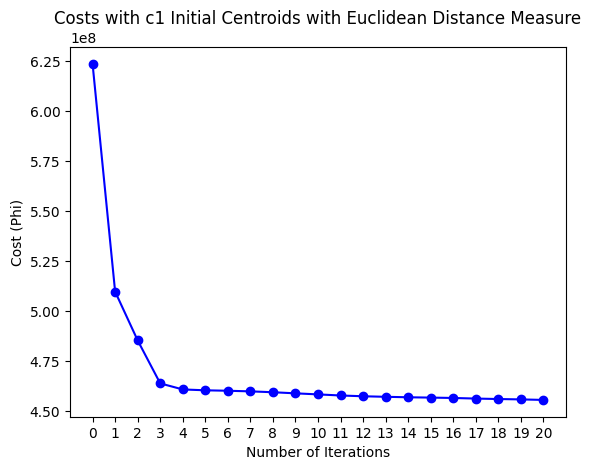

In [ ]:
# Generate a plot for c1 centroid initializations with Euclidean distance metric
i = [x for x in range(21)]
plt.plot(i, costs_c1_euclidean, 'bo-')
plt.xticks(i)
plt.xlabel("Number of Iterations")
plt.ylabel("Cost (Phi)")
plt.title("Costs with c1 Initial Centroids with Euclidean Distance Measure")
plt.show()

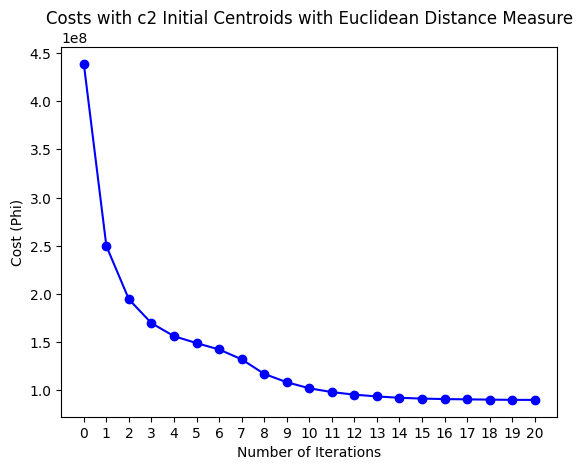

In [ ]:
# Generate a plot for c2 centroid initializations with Euclidean distance metric
i = [x for x in range(21)]
plt.plot(i, costs_c2_euclidean, 'bo-')
plt.xticks(i)
plt.xlabel("Number of Iterations")
plt.ylabel("Cost (Phi)")
plt.title("Costs with c2 Initial Centroids with Euclidean Distance Measure")
plt.show()

Using Manhattan distance to compute psi(i) for every iteration i.

In [ ]:
# Run kmeans for c1 centroid initializations with Manhattan distance metric
dataset, centroids_c1 = preprocess_dataset(documents, c1)
km_c1_manhattan = my_kmeans(data=dataset, centroids = centroids_c1, k = 10, max_iter = 20, distance_measure=manhattan_distance, cost_measure=compute_psi)
centroids_c1_manhattan, assignments_c1_manhattan, costs_c1_manhattan = km_c1_manhattan.run_kmeans()

In [ ]:
# Run kmeans for c2 centroid initializations with Manhattan distance metric
dataset, centroids_c2 = preprocess_dataset(documents, c2)
km_c2_manhattan = my_kmeans(data=dataset, centroids = centroids_c2, k = 10, max_iter = 20, distance_measure=manhattan_distance, cost_measure=compute_psi)
centroids_c2_manhattan, assignments_c2_manhattan, costs_c2_manhattan = km_c2_manhattan.run_kmeans()

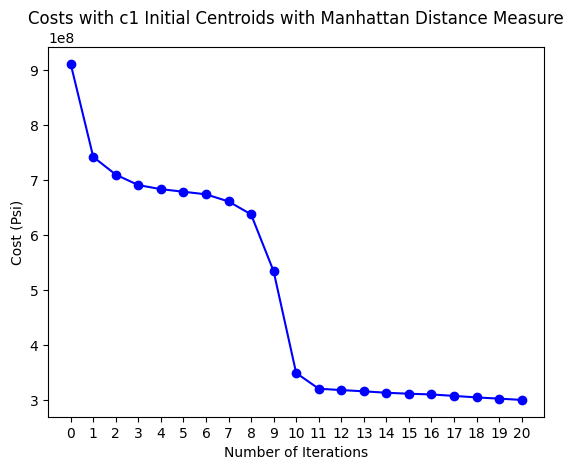

In [ ]:
# Generate a plot for c1 centroid initializations with Manhattan distance metric
i = [x for x in range(21)]
plt.plot(i, costs_c1_manhattan, 'bo-')
plt.xticks(i)
plt.xlabel("Number of Iterations")
plt.ylabel("Cost (Psi)")
plt.title("Costs with c1 Initial Centroids with Manhattan Distance Measure")
plt.show()

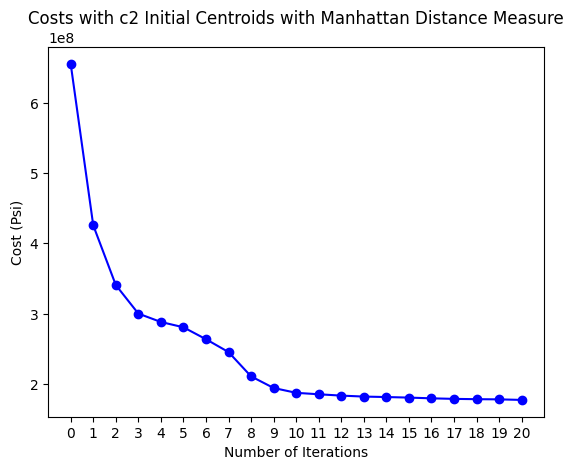

In [ ]:
# Generate a plot for c2 centroid initializations with Manhattan distance metric
i = [x for x in range(21)]
plt.plot(i, costs_c2_manhattan, 'bo-')
plt.xticks(i)
plt.xlabel("Number of Iterations")
plt.ylabel("Cost (Psi)")
plt.title("Costs with c2 Initial Centroids with Manhattan Distance Measure")
plt.show()

In [ ]:
# stop the spark instance
sc.stop()